In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler

In [3]:
def mape_func(data, target_date):
    group_data = data.groupby(by='Date')
    target_date = data.loc[target_date].index[1]                 #用于mape的时间
    x_pred = data.loc[target_date, 'D'].values.flatten()
    def mapes(x_true,x_pred =x_pred):
        y = x_true['D'].values.flatten()
        x = x_pred
        mape = np.mean(np.abs(x - y)/x)*100
        return mape
       
    mape_data = group_data.apply(mapes)
    vaild_index = np.array([])
    train_index = np.array([])
    for i in mape_data.sort_values()[1:81].index.sort_values():
        a = i + datetime.timedelta(days=1)
        if a in data_index:
            train_index = np.append(train_index, i)
            vaild_index = np.append(vaild_index, a)
        else:
            continue
    return train_index,vaild_index


In [4]:
def reshape_data(index_T, index_V, data):
    sc_temp = MinMaxScaler()
    data['CT'] = sc_temp.fit_transform(data['CT'].values.reshape(-1,1))
    data['IT'] = sc_temp.transform(data['IT'].values.reshape(-1,1))
    data['FT'] = sc_temp.transform(data['FT'].values.reshape(-1,1))
    sc_load = MinMaxScaler()
    data['D'] = sc_load.fit_transform(data['D'].values.reshape(-1,1))
    length = int(np.floor(index_T.shape[0]*0.7))
    print(length,'-------------------------------')
    X_train = data.loc[index_T].iloc[:length*24].values.reshape(-1,24,4)      
    y_train = data.loc[index_V].iloc[:length*24, 0].values.reshape(-1,24)    
    X_test = data.loc[index_T].iloc[length*24:].values.reshape(-1,24,4)
    y_test = data.loc[index_V].iloc[length*24:, 0].values.reshape(-1,24)
    
    #X_train, X_test, y_train, y_test = train_test_split(data.loc[index_T], data.loc[index_V, 'load'], test_size=0.3)
    return [X_train, X_test, y_train, y_test, sc_temp, sc_load]


In [5]:
def modle_set():
    #建立LSTM模型 训练
    inputs=tf.keras.layers.Input(shape=(24, 4))
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    #model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)
    #model=tf.keras.layers.MaxPooling1D(pool_size = 48)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    #model=tf.keras.layers.GRU(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh')(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(24)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

In [15]:
def mainSet(data, target_date, aim_data):   
    data_real = data.copy()                                                                           #未归一化的datarale
    
    
    train_index,vaild_index = mape_func(data, target_date)
    a = reshape_data(train_index, vaild_index, data)                                                  #会将data     normolization
    
    model = modle_set()
    model.fit(a[0], a[2], epochs = 30, batch_size = 5,shuffle=True,validation_data=(a[1], a[3]))   #训练模型--专属

    for_pred = data.loc[target_date].values.reshape(1,24,4)                                            #用前一天

    pred_data = model.predict(for_pred)                                                                #预测后一天
    pred_data_true = a[-1].inverse_transform(pred_data.reshape(-1,1)).flatten()
    true_value = data_real.loc[aim_data,'D'].values.flatten()                                       #后一天的真实值 
    
    #print(target_date, 'to predict', aim_data)
    
    plt.plot(pred_data_true, 'b')
    plt.plot(true_value,'r')
    plt.show()
    
    #print('pred')
    #print(pred_data_true)
    #print('true')
    #print(true_value)
    mapes = np.mean(np.abs(true_value - pred_data_true)/true_value)*100
    #print('mape:', mapes)
    return pred_data_true, true_value, mapes

55 -------------------------------
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 24, 24)            120       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_25 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

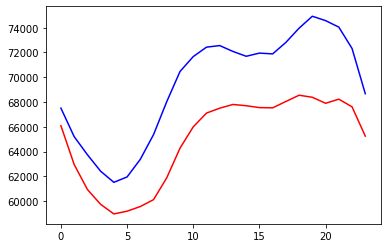

6.7753386662702715

In [31]:
data = pd.read_csv('weekend.csv', index_col=['Date'], parse_dates=['Date'])
data_index = data.index.unique()
pred_data, true_data, mapes = mainSet(data, '2021-05-28', '2021-05-29')
mapes

In [11]:
pred_data #2  2.3609

array([61894.598, 59662.645, 58520.3  , 57413.24 , 56489.008, 56764.83 ,
       57126.055, 57747.94 , 59718.477, 62562.754, 64653.793, 65934.51 ,
       67041.74 , 66988.62 , 68123.27 , 67900.56 , 68687.65 , 69272.6  ,
       70517.12 , 71031.48 , 70964.71 , 71696.   , 69120.5  , 65486.48 ],
      dtype=float32)

In [18]:
pred_data #8 2.770943852650967

array([64029.65 , 62609.688, 60259.484, 59977.07 , 60265.625, 60601.164,
       61702.3  , 63401.777, 64994.168, 67511.805, 68570.83 , 68814.15 ,
       68935.23 , 69431.88 , 69053.76 , 69878.33 , 70734.57 , 70712.64 ,
       72124.49 , 73230.48 , 73919.27 , 73253.7  , 71594.33 , 67129.44 ],
      dtype=float32)

In [21]:
pred_data#9 1.6307168978256033

array([61942.902, 59532.133, 58487.188, 57291.867, 56790.652, 56995.156,
       57593.52 , 58253.195, 60283.51 , 62581.06 , 64598.773, 65733.55 ,
       66431.18 , 67284.516, 67259.28 , 67424.484, 67686.914, 69008.734,
       69963.83 , 70285.27 , 70396.95 , 70957.586, 68631.71 , 65514.137],
      dtype=float32)

In [24]:
pred_data#15 4.214384033577299

array([65823.555, 63400.42 , 60816.465, 60670.367, 59063.76 , 60229.22 ,
       61446.92 , 64087.254, 65095.164, 67890.76 , 68689.555, 68987.34 ,
       69565.67 , 69987.734, 69998.04 , 70624.56 , 70156.516, 70916.984,
       72903.31 , 74500.414, 74447.055, 73140.43 , 71783.62 , 68698.73 ],
      dtype=float32)

In [26]:
pred_data#16 2.26431843032

array([62016.65 , 60477.523, 57906.74 , 57049.59 , 56210.832, 57441.625,
       57686.383, 58474.88 , 59551.324, 61807.24 , 64980.656, 65876.94 ,
       66377.78 , 67409.42 , 67901.49 , 67934.375, 69028.17 , 69478.14 ,
       70234.016, 70904.44 , 70630.14 , 70514.46 , 69037.63 , 65448.926],
      dtype=float32)

In [28]:
pred_data#22 1.3789698873587581

array([73729.22 , 70151.09 , 66349.19 , 65658.3  , 64208.895, 64836.707,
       64187.207, 64432.164, 67697.94 , 72505.21 , 76090.23 , 78894.17 ,
       82068.15 , 83859.8  , 86027.48 , 88327.13 , 88384.945, 89391.516,
       89950.95 , 88044.664, 86354.805, 84342.   , 83254.33 , 77846.41 ],
      dtype=float32)

In [30]:
pred_data#23 2.4688763456800213

array([71655.734, 68051.94 , 64880.38 , 63358.605, 62329.055, 62530.6  ,
       62895.254, 62991.805, 64894.008, 68969.12 , 72590.64 , 76620.664,
       78455.555, 81556.2  , 82980.15 , 84395.5  , 84884.33 , 86094.11 ,
       86055.25 , 85119.305, 83580.59 , 82045.04 , 79973.09 , 75867.1  ],
      dtype=float32)

In [32]:
 pred_data#29 6.775338

array([67506.99 , 65212.22 , 63753.29 , 62419.9  , 61522.88 , 61956.953,
       63379.95 , 65375.1  , 68036.65 , 70466.11 , 71667.016, 72427.3  ,
       72555.04 , 72081.92 , 71692.03 , 71947.53 , 71883.91 , 72811.375,
       73962.32 , 74921.72 , 74568.24 , 74043.73 , 72319.914, 68673.6  ],
      dtype=float32)

In [33]:
ass = np.array([61894.598, 59662.645, 58520.3  , 57413.24 , 56489.008, 56764.83 ,
       57126.055, 57747.94 , 59718.477, 62562.754, 64653.793, 65934.51 ,
       67041.74 , 66988.62 , 68123.27 , 67900.56 , 68687.65 , 69272.6  ,
       70517.12 , 71031.48 , 70964.71 , 71696.   , 69120.5  , 65486.48,
        64029.65 , 62609.688, 60259.484, 59977.07 , 60265.625, 60601.164,
       61702.3  , 63401.777, 64994.168, 67511.805, 68570.83 , 68814.15 ,
       68935.23 , 69431.88 , 69053.76 , 69878.33 , 70734.57 , 70712.64 ,
       72124.49 , 73230.48 , 73919.27 , 73253.7  , 71594.33 , 67129.44,
        61942.902, 59532.133, 58487.188, 57291.867, 56790.652, 56995.156,
       57593.52 , 58253.195, 60283.51 , 62581.06 , 64598.773, 65733.55 ,
       66431.18 , 67284.516, 67259.28 , 67424.484, 67686.914, 69008.734,
       69963.83 , 70285.27 , 70396.95 , 70957.586, 68631.71 , 65514.137,
        65823.555, 63400.42 , 60816.465, 60670.367, 59063.76 , 60229.22 ,
       61446.92 , 64087.254, 65095.164, 67890.76 , 68689.555, 68987.34 ,
       69565.67 , 69987.734, 69998.04 , 70624.56 , 70156.516, 70916.984,
       72903.31 , 74500.414, 74447.055, 73140.43 , 71783.62 , 68698.73,
        62016.65 , 60477.523, 57906.74 , 57049.59 , 56210.832, 57441.625,
       57686.383, 58474.88 , 59551.324, 61807.24 , 64980.656, 65876.94 ,
       66377.78 , 67409.42 , 67901.49 , 67934.375, 69028.17 , 69478.14 ,
       70234.016, 70904.44 , 70630.14 , 70514.46 , 69037.63 , 65448.926,
       73729.22 , 70151.09 , 66349.19 , 65658.3  , 64208.895, 64836.707,
       64187.207, 64432.164, 67697.94 , 72505.21 , 76090.23 , 78894.17 ,
       82068.15 , 83859.8  , 86027.48 , 88327.13 , 88384.945, 89391.516,
       89950.95 , 88044.664, 86354.805, 84342.   , 83254.33 , 77846.41,
        71655.734, 68051.94 , 64880.38 , 63358.605, 62329.055, 62530.6  ,
       62895.254, 62991.805, 64894.008, 68969.12 , 72590.64 , 76620.664,
       78455.555, 81556.2  , 82980.15 , 84395.5  , 84884.33 , 86094.11 ,
       86055.25 , 85119.305, 83580.59 , 82045.04 , 79973.09 , 75867.1,
        67506.99 , 65212.22 , 63753.29 , 62419.9  , 61522.88 , 61956.953,
       63379.95 , 65375.1  , 68036.65 , 70466.11 , 71667.016, 72427.3  ,
       72555.04 , 72081.92 , 71692.03 , 71947.53 , 71883.91 , 72811.375,
       73962.32 , 74921.72 , 74568.24 , 74043.73 , 72319.914, 68673.6 ])

In [35]:
pd.DataFrame(ass.reshape(-1,24)).to_csv('weekend_pred.csv')